In [43]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [44]:
cd /

C:\


In [45]:
cd Penn State\Projects\TR

C:\Penn State\Projects\TR


In [46]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [47]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000014666AEA0B8>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000014666AEAEF0>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000014600497D68>)

# Model Inputs

In [48]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    return inputs_real, inputs_z

# Variable Scope

we can use the reuse keyword for tf.variable_scope to tell TensorFlow to reuse the variables instead of creating new ones if we build the graph again

In [49]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.nn.tanh(logits)
        
        return out, logits

In [50]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.nn.sigmoid(logits)
        
        return out, logits


# Hyperparameter

In [51]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

# Build network

Generator : generator(input_z, input_size)<br>
Discriminator 1(Real): discriminator(input_real)<br>
Discriminator 2(Fake): discriminator(g_model, reuse=True)<br>
we use same weights for both discriminators

In [52]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model, g_logits = generator(input_z, input_size, g_hidden_size, reuse=False,  alpha=alpha)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, d_hidden_size, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, d_hidden_size, reuse=True, alpha=alpha)

# Discriminator and Generator Losses

Discriminator:<br>
d_loss = d_loss_real + d_loss_fake<br>
real image logits : d_logits_real which we got from the discriminator<br>
labels : All 1's as images input to discriminator are real<br>
We will do label smoothing for better generalisation of discrimonator<br>
d_labels_real : Ones
d_labels_fake : Zeros

Generator:<br>
    Generator wants to fool the discriminator, so it will take fake discriminator output as logit and compare with real Discriminator labels(all 1's)



In [53]:
# Calculate losses
d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)

d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake), 
        logits=d_logits_fake))


# Optimizers

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with generator. So, we just need to iterate through the list from tf.trainable_variables() and keep variables that start with generator. Each variable object has an attribute name which holds the name of the variable as a string (var.name == 'weights_0' for instance).<br>

We can do something similar with the discriminator. All the variables in the discriminator start with discriminator.

In [54]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

# Training

In [55]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784)) #Ensure shape
            batch_images = batch_images*2 - 1 #Rescale
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
            
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3557... Generator Loss: 3.9988
Epoch 2/100... Discriminator Loss: 0.3508... Generator Loss: 4.2014
Epoch 3/100... Discriminator Loss: 0.4037... Generator Loss: 3.1687
Epoch 4/100... Discriminator Loss: 0.5847... Generator Loss: 2.8451
Epoch 5/100... Discriminator Loss: 0.7024... Generator Loss: 3.7607
Epoch 6/100... Discriminator Loss: 1.2331... Generator Loss: 4.0553
Epoch 7/100... Discriminator Loss: 1.0125... Generator Loss: 1.5451
Epoch 8/100... Discriminator Loss: 0.6970... Generator Loss: 2.3227
Epoch 9/100... Discriminator Loss: 0.9192... Generator Loss: 2.6195
Epoch 10/100... Discriminator Loss: 0.9848... Generator Loss: 2.1571
Epoch 11/100... Discriminator Loss: 0.7754... Generator Loss: 3.6655
Epoch 12/100... Discriminator Loss: 1.3606... Generator Loss: 1.9425
Epoch 13/100... Discriminator Loss: 0.8495... Generator Loss: 3.7644
Epoch 14/100... Discriminator Loss: 1.2942... Generator Loss: 1.8185
Epoch 15/100... Discriminator Loss: 0.8184.

# Train Loss Visualization

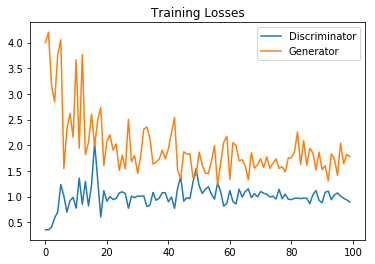

In [56]:
%matplotlib inline

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [130]:
def view_samples(epoch, samples):
    #print(epoch)
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[99][0]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [131]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

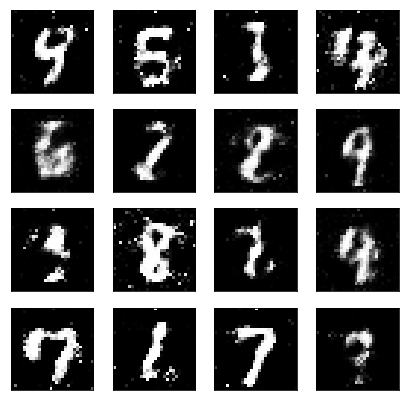

In [132]:
_ = view_samples(-1, samples)

# Epochwise image formation

In [139]:
sample_set= []
for i in range(10):
    sample_set.append(samples[i*11][0][:6])

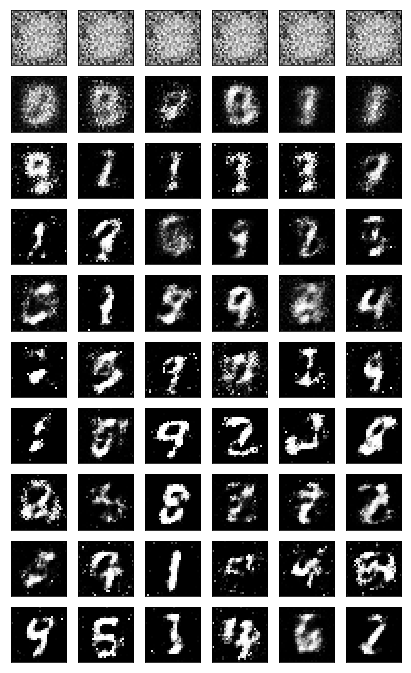

In [141]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample_subset, ax_row in zip(sample_set, axes):
    for img, ax in zip(sample_subset, ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
